## Notebook for Figure 3 and related content: Beta Cells Heterogeneity, Predictive Set of genes for Electrophysiology
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
import matplotlib.patches as mpatches
import pickle
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from matplotlib import cm
%matplotlib inline

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [3]:
%run ./../functions/helper_functions.py
%run ./../functions/predictions.py

In [4]:
root_folder = './../data/'
analysis_folder = './../analysis/'
figures_folder = './../figures/fig3_suppfig4/'

## tSNE plots on beta cell  heterogeneity

In [5]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

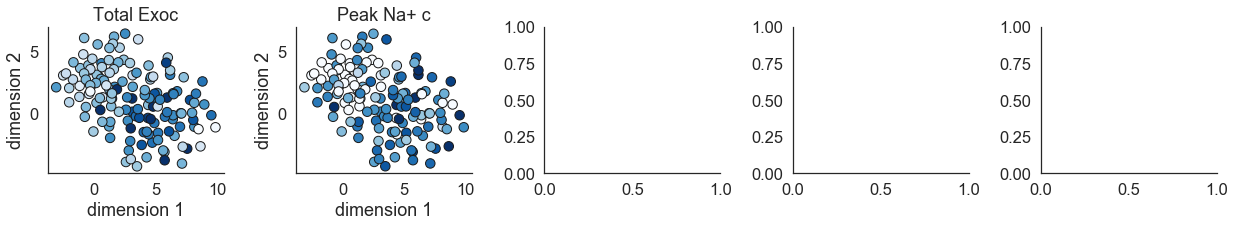

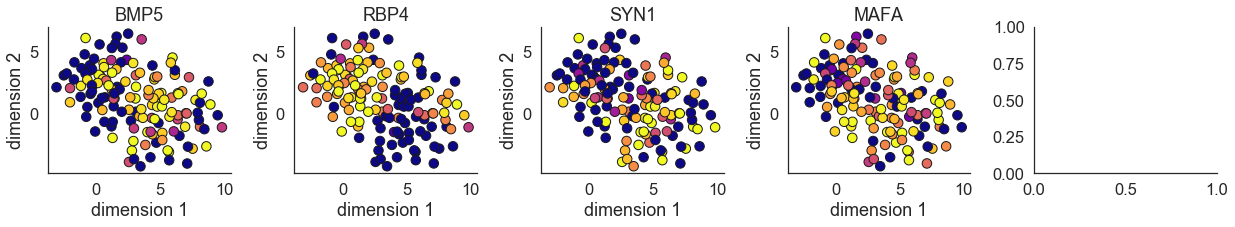

In [7]:
# Read correlated genes from beta cell dataset
dir_beta= analysis_folder + 'correlations_betacell/beta_correlations_all/beta_ND/'

#select correlated genes to ephys to perform tsne embedding
results_corr = import_correlations_folder(dir_name=dir_beta,
                          substring_pattern='beta_healthy_(.+?)_10')
x1 = filter_correlation_table(results_corr, z_th = 2, zscore_raw=True,pct_th = 30, raw_corr_th=0.1, p_boot_th=1e-3, n_feat=4,n_blocks=1, signed='positive')
x2 = filter_correlation_table(results_corr, z_th = 2, zscore_raw=True,pct_th = 30, raw_corr_th=0.1, p_boot_th=1e-3, n_feat=4,n_blocks=1, signed='negative')
x=pd.concat([x1,x2])
x = x[~x.index.str.contains('^AC|^RPL|^RPS|^MRPL|^MRPS|MTND4P12')]

#cells to plot
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy'],
                   'Patched': ['Yes'],#,
                   'TimefromDispersion_days': [1,2,3,4],
                   'Glucose_mM': [5,10]}#,
                  # 'Glucose_mM': [1,5,10]}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)
ts = filtered_dataset

#Select relevant genes and parameters to plot 
gene_list = x.index.tolist()
pars =['Total Exocitosis','Peak Na+ current']
genes_plot = ['BMP5','RBP4','SYN1','MAFA']
sns.set(font_scale=1.5)

#clip electrophysiology below 0, and clip at 95% percentile
#make logarithm of electrophysiology values
for par in pars:
    s1 = np.nan_to_num(np.abs(ts.samplesheet[par]))
    clip_val = np.percentile(s1, q=95)
    s1 = np.clip(s1,0,clip_val)
    ts.samplesheet[par+'log'] = np.log(s1+0.5)

#compute tsne using genelist (correlated genes)
ts.counts = ts.counts.loc[gene_list,:] 
ts.counts.dropna(inplace=True)
dims = ts.dimensionality.tsne()

#cut values extreme in expression 10-90%
clip_min = ts.counts.quantile(q=0.1,axis=1)
clip_max = ts.counts.quantile(q=0.9,axis=1)
ts.counts = ts.counts.clip(clip_min,clip_max,axis=0)

new_cmap = shiftedColorMap(cm.get_cmap('Blues'), start=0.0, midpoint=0.6, stop=1, name='shrunk')
sns.set_style('white')
#plot log quantile cut parameters
n_cols=5
n_rows=int(len(pars)/n_cols+1)
fig3, axs3 = plt.subplots(n_rows,n_cols, figsize=(3.5*n_cols,3.5*n_rows))
axs3= axs3.flatten()
for i,par in enumerate(pars):
    ts.plot.scatter_reduced_samples(dims,color_by=par+'log', ax=axs3[i], title=par[0:10], cmap=new_cmap,lw=1,edgecolor='k')
    axs3[i].grid(False)
sns.despine()
fig3.savefig(figures_folder +'fig3b_ephys.pdf')
n_cols=5

n_rows=int(len(genes_plot)/n_cols+1)
#plot genes
fig, axs = plt.subplots(n_rows,n_cols, figsize=(3.5*n_cols,3.5*n_rows))
axs= axs.flatten()
for i,gene in enumerate(genes_plot):
    axs[i] = ts.plot.scatter_reduced_samples(dims,color_by=gene, ax=axs[i], title=gene, cmap='plasma', lw=1,edgecolor='k')
    axs[i].grid(False)
sns.despine()
fig.savefig(figures_folder +'fig3b_genes.pdf')

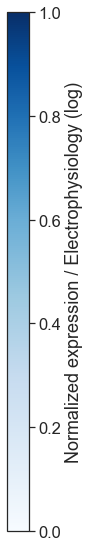

In [8]:
#make colorbar
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(2, 8))
ax1 = fig.add_axes([0.1, 0.05, 0.15,0.9])


cmap = make_colormap_from_colorlist(list_colors=['#c6dbef','#08306b'],
                              bins=50)
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=new_cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Normalized expression / Electrophysiology (log)')
fig.savefig(figures_folder +'fig3b_genes_colorbar.pdf')

## PS gene set and electrophysiology prediction

### Load cells from train test split

In [9]:
## Read train and test datasets

file1= analysis_folder + 'correlations_betacell/train_ds.pickle'
file2= analysis_folder + 'correlations_betacell/test_ds.pickle'

with open(file1, 'rb') as f:
    ds_train = pickle.load(f)
with open(file2, 'rb') as f:
    ds_test = pickle.load(f)

ds_train.samplesheet = filter_dataset_ephys(ds_train.samplesheet,qlow=0.0,qhigh=1, include_quantiles=True, clipzero=True, removeneg=False,clip_quant=True, clip_qlow=0,clip_qhigh=0.9)
ds_test.samplesheet = filter_dataset_ephys(ds_test.samplesheet,qlow=0.0,qhigh=1, include_quantiles=True, clipzero=False, removeneg=True,clip_quant=True, clip_qlow=0,clip_qhigh=0.95)

### Select cells and correlations and do prediction in train and test set

Use train / test set split (80/20%) to perform analysis. 5 kNN neighbours. PS gene set witg z-score >2, genes that are observed in at least two functional groups, filter out low expressed genes (log2:median>0)

In [10]:
# Read correlated genes and select hubs for prediction
dir_beta= analysis_folder + 'correlations_betacell/beta_correlations_traintestsplit20'

results_corr = import_correlations_folder(dir_name=dir_beta,
                          substring_pattern='beta_healthy_(.+?)_10')

PS_genes = {}
list_genes = ['positive','negative','both']

#prepare additional gene info
x = ds_train.counts
expression = pd.concat([percent_exp(x).round(2),
                        (2**logmean(x)).round(2),
                        logmean(x).round(2),
                        x.median(axis=1).round(2)],
                       axis=1,
                       keys=['pct_expr','mean (cpm)','log2 mean (cpm),','log2 median (cpm)'])
#make dictionary with gene lists
for subset in list_genes:
    PS_genes[subset] = filter_correlation_table(results_corr, 
                                                 z_th = 2, 
                                                 zscore_raw=True, 
                                                 pct_th = 0., 
                                                 raw_corr_th=0., 
                                                 p_boot_th=1, 
                                                 n_feat=1, 
                                                 n_blocks=2, 
                                                 signed=subset)
    PS_genes[subset] = pd.concat([PS_genes[subset] ,expression],join='inner',axis=1)


In [11]:
#Fix parameters to test and method
phenotypes = ['Cell size',
              'Total Exocitosis', 'Early exocytosis','Late exocytosis', 
              'Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ Conductance',
              'Na+ conductance', 'Peak Na+ current']

genelist = PS_genes['both'][PS_genes['both']['log2 median (cpm)']>0].index.tolist()
n_cells=5
method= 'spearman'
weighted_method='flat'
####

#prepare train and test
x = ds_train.counts
x_electro = ds_train.samplesheet.loc[:,phenotypes]
y = ds_test.counts
y_electro = ds_test.samplesheet.loc[:,phenotypes]

#remove cells with NA in the train dataset
x_electro = x_electro.dropna(axis=0)

#make sure counts match electrophysiology
x =x.loc[:,x_electro.index]
y=y.loc[:,y_electro.index]

#predict
res_pred_train = predict_ephys(x, x, genelist, x_electro, k=n_cells, method=method, weight_method=weighted_method, use_top_cell=False)
res_pred_test = predict_ephys(y, x, genelist, x_electro, k=n_cells, method=method, weight_method=weighted_method, use_top_cell=True)

#clean initial columns with top cells
for col in y_electro.columns:
    res_pred_train[col] = x_electro[col]
    res_pred_test[col] = y_electro[col]

res_pred_train.drop(np.arange(n_cells)+1,axis=1,inplace=True)
res_pred_test.drop(np.arange(n_cells)+1,axis=1,inplace=True)

#output metrica
corr_train = {}
mae_train = {}
corr_test = {}
mae_test = {}
pval_test = {}
#save correlations for distribution plot    
for i,par in enumerate(phenotypes):
    temp = res_pred_train[[par, par + ' mean']].dropna(axis=0)
    mae_train[par] = mean_absolute_error(temp[par],temp[par + ' mean'])
    spr = spearmanr(res_pred_train[par],res_pred_train[par + ' mean'],nan_policy='omit')
    corr_train[par] = spr.correlation
    temp = res_pred_test[[par, par + ' mean']].dropna(axis=0)
    mae_test[par] = mean_absolute_error(temp[par],temp[par + ' mean'])
    spr = spearmanr(res_pred_test[par],res_pred_test[par + ' mean'],nan_policy='omit')
    #probability for spearman is for values as extreme as the observed (one sided test as only positive side)
    #this seems also more consistent with probabilities from random list of genes
    corr_test[par] = spr.correlation
    pval_test[par] = spr.pvalue /2

#make dataframe with fit metrics   
r_corr = pd.DataFrame.from_dict([corr_train,mae_train,corr_test,mae_test,pval_test])
r_corr.rename(index={0:'corr_train',1:'mae_train',2:'corr_test',3:'mae_test',4:'pval_test'}, inplace=True)
metrics_psgeneset = r_corr

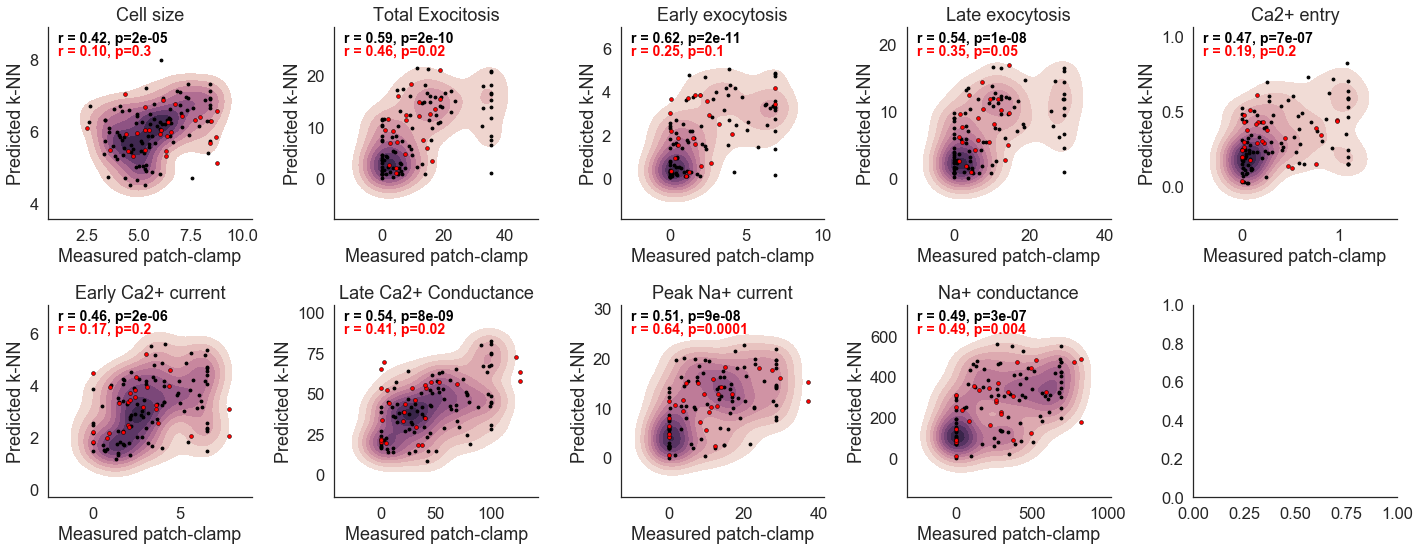

In [12]:
#Plot predictions
pars=['Cell size', 
      'Total Exocitosis','Early exocytosis','Late exocytosis',
      'Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ Conductance',
      'Peak Na+ current','Na+ conductance']

f, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)

# Rotate the starting point around the cubehelix hue circle
for ax, s, par in zip(axes.flat, np.linspace(0, 3, 10), pars):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    # Generate and plot a random bivariate dataset
    z = res_pred_train[[par,par+' mean']].dropna()
    z2 = res_pred_test[[par,par+' mean']].dropna()
    r_tr =  spearmanr(z.iloc[:,0],z.iloc[:,1])
    r_ts =  spearmanr(z2.iloc[:,0],z2.iloc[:,1])
    #probability for spearman is for values as extreme as the observed (one sided test as only positive side)
    #this seems also more consistent with probabilities from random list of genes
    r_tr = [r_tr.correlation,r_tr.pvalue/2]
    r_ts = [r_ts.correlation,r_ts.pvalue/2]
    
    sns.kdeplot(z[par], z[par+' mean'], cmap=cmap, shade=True,shade_lowest=False,ax=ax)
    ax.scatter(z[par], z[par+' mean'], s=8, c='black',marker='o', lw=1, edgecolors='black')
    ax.scatter(z2[par], z2[par+' mean'], s=15, c='red',marker='o', lw=0.5, edgecolors='black')
    ax.text(0.05, 0.92, 'r = {data[0]:01.2f}, p={data[1]:01.1g}'.format(data = r_tr), fontsize=14, transform=ax.transAxes,weight='bold',color='black')
    ax.text(0.05, 0.85, 'r = {data[0]:01.2f}, p={data[1]:01.1g}'.format(data = r_ts), fontsize=14, transform=ax.transAxes,weight='bold',color='red')
    
    ax.set_ylabel('Predicted k-NN')
    ax.set_xlabel('Measured patch-clamp')
    ax.set_title(par)

f.tight_layout()
sns.despine()
f.savefig(figures_folder +'fig3d_suppfig3a.pdf')


### Compute predictions for random genes  of same size than PS gene set

Compute predictions for subset of genes of each functional group and make spider plots with model performance

In [13]:
#Length of PS gene set
len(genelist)

484

In [14]:
#Build model, compute correlations and pvalues for random genes
corr_rand, mae_rand = make_predictions_random_genes(x, x_electro, x, x_electro, use_top=False, n_cells = 5, n_bootstrap = 1000, n_genes = 484, method = 'spearman', weight_method= 'flat')
corr_randtst, mae_randtst = make_predictions_random_genes(x, x_electro, y, y_electro, use_top=True, n_cells = 5, n_bootstrap = 1000, n_genes = 484, method = 'spearman', weight_method= 'flat')

pval_rand_train = correlation_pval_random(r_corr.T['corr_train'], corr_rand)
pval_rand_test= correlation_pval_random(r_corr.T['corr_test'], corr_randtst)

In [15]:
# Determine sets of genes correlated to each functional group and concatenat
# with table with average expression per gene
grouped_genes = get_group_genes(correlations_dict= results_corr,column_use='zscore_raw_mean')       
grouped_genes_expr = pd.concat([grouped_genes ,expression],join='inner',axis=1)

In [16]:
#Compute predictions based on each set of genes with same parameters than for PS gene set
phenotypes = ['Cell size', 'Total Exocitosis',  'Early exocytosis','Late exocytosis', 
        'Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ Conductance',
        'Na+ conductance', 'Peak Na+ current']

partypes = ['Cell size', 'Exocytosis', 'Calcium', 'Sodium']
n_cells=5
method= 'spearman'
weighted_method='flat'
corr_toplists = {}

for parclass in partypes:
    top = ((np.abs(grouped_genes_expr[parclass])>2) & (grouped_genes_expr['log2 median (cpm)']>0))

    #modules: Cell size	Exocytosis	Calcium	Sodium]
    genelist = grouped_genes_expr[top].index.tolist()

    ####
    #prepare train and test
    x = ds_train.counts
    x_electro = ds_train.samplesheet.loc[:,phenotypes]
    y = ds_test.counts
    y_electro = ds_test.samplesheet.loc[:,phenotypes]

    #remove cells with NA in the train dataset
    x_electro = x_electro.dropna(axis=0)

    #make sure counts match electrophysiology
    x =x.loc[:,x_electro.index]
    y=y.loc[:,y_electro.index]

    #predict
    res_pred_train = predict_ephys(x, x, genelist, x_electro, k=n_cells, method=method, weight_method=weighted_method, use_top_cell=False)
    res_pred_test = predict_ephys(y, x, genelist, x_electro, k=n_cells, method=method, weight_method=weighted_method, use_top_cell=True)

    #clean initial columns with top cells
    for col in y_electro.columns:
        res_pred_train[col] = x_electro[col]
        res_pred_test[col] = y_electro[col]

    res_pred_train.drop(np.arange(n_cells)+1,axis=1,inplace=True)
    res_pred_test.drop(np.arange(n_cells)+1,axis=1,inplace=True)

    #output metrica
    corr_train = {}
    mae_train = {}
    corr_test = {}
    mae_test = {}
    #save correlations for distribution plot    
    for i,par in enumerate(phenotypes):
        temp = res_pred_train[[par, par + ' mean']].dropna(axis=0)
        mae_train[par] = mean_absolute_error(temp[par],temp[par + ' mean'])
        spr = spearmanr(res_pred_train[par],res_pred_train[par + ' mean'],nan_policy='omit')
        corr_train[par] = spr.correlation
        temp = res_pred_test[[par, par + ' mean']].dropna(axis=0)
        mae_test[par] = mean_absolute_error(temp[par],temp[par + ' mean'])
        spr = spearmanr(res_pred_test[par],res_pred_test[par + ' mean'],nan_policy='omit')
        corr_test[par] = spr.correlation
        pval_test[par] = spr.pvalue / 2

    temp_res = pd.DataFrame.from_dict([corr_train,mae_train,corr_test,mae_test])#
    temp_res.rename(index={0:'corr_train',1:'mae_train',2:'corr_test',3:'mae_test',4:'pval_test'}, inplace=True)
    #save result for this set of parameters in dict
    corr_toplists[parclass] = temp_res
    

In [17]:
#Compute performance for random genes (mean and q95)
random_genes = corr_rand.mean(axis=1).rename('random genes, mean').T
random_genes_q95 = corr_rand.quantile(q=0.94,axis=1).rename('random genes, CI:95%').T
#Compute performance for functional group gene sets
oorr_optim_par = pd.concat([corr_toplists[par].loc['corr_train',:] for par in partypes],axis=1,keys=partypes).T

#concatenate results into final table of performances
df = pd.DataFrame(data=[r_corr.T['corr_train'],r_corr.T['corr_test']], 
                  index=['PS genes','PS genes (validation)'])
df = pd.concat([pd.DataFrame(random_genes).T,pd.DataFrame(random_genes_q95).T,df,oorr_optim_par])
df.reset_index(inplace=True)
df = df.rename(columns={'index':'group'})
num_col = ['Cell size','Total Exocitosis','Early exocytosis', 'Late exocytosis', 'Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ Conductance', 'Peak Na+ current', 'Na+ conductance']

df[num_col] = df[num_col].clip_lower(0)
order_col = ['group','Cell size','Total Exocitosis','Early exocytosis', 'Late exocytosis', 'Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ Conductance', 'Peak Na+ current', 'Na+ conductance']
df = df.loc[[1,0,2,3,4,5,6,7],order_col]
df.reset_index(drop=True, inplace=True)

In [18]:
df

,group,Cell size,Total Exocitosis,Early exocytosis,Late exocytosis,Ca2+ entry,Early Ca2+ current,Late Ca2+ Conductance,Peak Na+ current,Na+ conductance
0,"random genes, CI:95%",0.282068,0.317716,0.324347,0.279129,0.184442,0.168691,0.221042,0.283216,0.270977
1,"random genes, mean",0.112269,0.134394,0.154692,0.106737,0.009272,0.000639,0.063650,0.106423,0.090572
2,PS genes,0.415331,0.588163,0.616308,0.539425,0.474842,0.459160,0.542690,0.507545,0.487595
3,PS genes (validation),0.101287,0.455239,0.254237,0.351313,0.190930,0.172319,0.410659,0.643022,0.489555
4,Cell size,0.707387,0.179311,0.199147,0.149688,0.064427,0.060574,0.071084,0.324318,0.352719
5,Exocytosis,0.234398,0.659640,0.649963,0.604530,0.199127,0.167186,0.124055,0.309016,0.353266
6,Calcium,0.145964,0.273905,0.195911,0.283186,0.655633,0.637355,0.614830,0.078761,0.123819
7,Sodium,0.088566,0.402285,0.355320,0.354357,0.199440,0.189254,0.314199,0.721257,0.665589


No handles with labels found to put in legend.


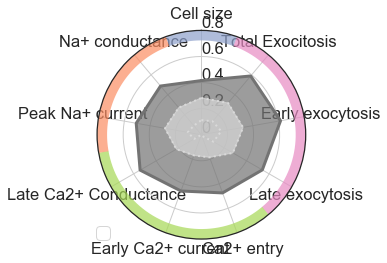

In [19]:
#make performance spider plots
from math import pi
sns.set(font_scale=1.5,style='white')
# 1:Make background
 
# number of variables
categories=list(df)[1:]
N = len(categories)
 
# Set angles in plit(we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise spider plot
ax = plt.subplot(111, polar=True)
 
# First axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, ha='center')

# Draw ylabels
ax.set_rlabel_position(0)
plt.ylim(0,0.8)
plt.yticks([0,0.2,0.4,0.6,0.8], [0,0.2,0.4,0.6,0.8])
 
#cell size
unit = 2 * pi / 9
ini=-unit/2
end=unit/2
theta = np.linspace(ini,end)
ax.plot(theta,[0.8 for t in theta],color='#8da0cb',linewidth=20, solid_capstyle='butt', alpha=0.7)  
#exocytosis
ini=end
end=ini + unit * 3
theta = np.linspace(ini, end)
ax.plot(theta,[0.8 for t in theta],color='#e78ac3',linewidth=20, solid_capstyle='butt', alpha=0.7)  
#calcium
ini=end
end=ini+unit * 3
theta = np.linspace(ini, end)
ax.plot(theta,[0.8 for t in theta],color='#a6d854',linewidth=20, solid_capstyle='butt', alpha=0.7)  
#sodium
ini=end
end=ini+unit * 2
theta = np.linspace(ini, end)
ax.plot(theta,[0.8 for t in theta],color='#fc8d62',linewidth=20, solid_capstyle='butt', alpha=0.7)  

# 2: Add plots
locs =[2]
colors= ['#737373']

for i,loc in enumerate(locs):
    values=df.loc[loc].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=3, linestyle='solid', c=colors[i])
    ax.fill(angles, values, c=colors[i], alpha=0.7)
    

locs =[1]
colors= ['#d9d9d9']

for i,loc in enumerate(locs):
    values=df.loc[loc].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='dotted', c=colors[i])

locs =[0]
colors= ['#d9d9d9']

for i,loc in enumerate(locs):
    values=df.loc[loc].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='dotted', c=colors[i])
    ax.fill(angles, values, c=colors[i], alpha=0.7)


locs =[3,4,5,6]
colors= ['#8da0cb',
'#e78ac3',
'#a6d854',
'#ffd92f',
'#ffd92f']

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout()
plt.savefig(figures_folder+'fig3E.pdf')

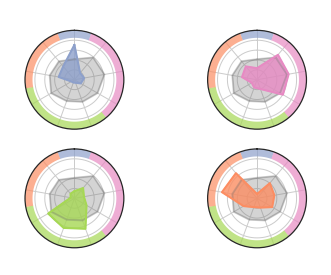

In [20]:
#make performance spider plots 2
def make_radial_base(ax):
    import matplotlib.pyplot as plt
    import pandas as pd
    from math import pi
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]


    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(str(' ') * len(angles[:-1])))

    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.2,0.4,0.6,0.8])
    ax.set_yticklabels(['','','','',''])

    #cell size
    unit = 2 * pi / 9
    ini=-unit/2
    end=unit/2
    theta = np.linspace(ini,end)
    ax.plot(theta,[1 for t in theta],color='#8da0cb',linewidth=15, solid_capstyle='butt', alpha=0.7)  
    #exocytosis
    ini=end
    end=ini + unit * 3
    theta = np.linspace(ini, end)
    ax.plot(theta,[1 for t in theta],color='#e78ac3',linewidth=15, solid_capstyle='butt', alpha=0.7)  
    #calcium
    ini=end
    end=ini+unit * 3
    theta = np.linspace(ini, end)
    ax.plot(theta,[1 for t in theta],color='#a6d854',linewidth=15, solid_capstyle='butt', alpha=0.7)  
    #sodium
    ini=end
    end=ini+unit * 2
    theta = np.linspace(ini, end)
    ax.plot(theta,[1 for t in theta],color='#fc8d62',linewidth=15, solid_capstyle='butt', alpha=0.7) 
    return ax
    
fig, axs =plt.subplots(2,2,subplot_kw=dict(polar=True))
axs = axs.flatten()

axs[0] = make_radial_base(axs[0])
axs[1] = make_radial_base(axs[1])
axs[2] = make_radial_base(axs[2])
axs[3] = make_radial_base(axs[3])

# Add plots
# Plot each individual = each line of the data
locs =[2]
colors= ['#737373']
for ax in axs:
    for i,loc in enumerate(locs):
        values=df.loc[loc].drop('group').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', c=colors[i],alpha=0.3)#,label=df.loc[locs,'group'])
        ax.fill(angles, values, c=colors[i], alpha=0.3)

locs =[4,5,6,7]
colors= ['#8da0cb',
'#e78ac3',
'#a6d854',
'#fc8d62',
'#e5c494']
for i,ax in enumerate(axs):
    values=df.loc[locs[i]].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', c=colors[i])#,label=df.loc[locs,'group'])
    ax.fill(angles, values, c=colors[i], alpha=0.8)


fig.savefig(figures_folder+'fig3E_2.pdf')

### Identify overlap of genes between functional groups and PS genes

In [21]:
partypes = ['Cell size', 'Exocytosis', 'Calcium', 'Sodium']

#read top genes for eachfunctional group
corr_toplists = {}
for parclass in partypes:
    top = ((np.abs(grouped_genes_expr[parclass])>2) & (grouped_genes_expr['log2 median (cpm)']>0))
    #modules: Cell size, Exocytosis, Calcium, Sodium]
    corr_toplists[parclass] = grouped_genes_expr[top].index.tolist()

#read PS genes    
corr_toplists['PS genes'] = PS_genes['both'][PS_genes['both']['log2 median (cpm)']>0].index.tolist()

#combine both tables
merged = corr_toplists['Calcium']+corr_toplists[ 'Exocytosis']+corr_toplists['Cell size']+corr_toplists['Sodium']

In [22]:
len(merged)

1144

In [23]:
genes_overlap = pd.read_csv(analysis_folder + 'PS_geneset_overlap/venn_overlap_PS_geneset.txt',sep='\t').fillna(method='ffill')
genes_overlap.head()

,Names,total,elements
0,Calcium Exocytosis PS genes Sodium,3.0,TIMM17A
1,Calcium Exocytosis PS genes Sodium,3.0,PSMB7
2,Calcium Exocytosis PS genes Sodium,3.0,SEZ6L
3,Cell size Exocytosis PS genes Sodium,6.0,SLC9A3R1
4,Cell size Exocytosis PS genes Sodium,6.0,HIGD1A
